# Using Python to Fit Molecular Junction Data

# The Single Level Tunneling Model

Here, I will try to focus on just how to code the various theories into python and use the fitting functions within the various python libraries to fit them. For an indepth analysis of landauer theory, please refer to section 1 of my thesis or to the theory paper published by Alvar.

I'll start this off by first showing the Equations for the Landauer theory here.

$$I = \dfrac{q}{\hbar}\int_{-\infty}^{\infty}dE D_\epsilon(E)\Gamma\left[f_L(E)-f_R(E)\right]$$

Where:

$$D_\epsilon(E) = \dfrac{\dfrac{\gamma_L+\gamma_R}{2}}{\left(E-\left(\epsilon+\left(\eta-\dfrac{1}{2}\right)\right)\right)^2+\left(\dfrac{\gamma_L+\gamma_R}{2}\right)^2}$$
<br>
<br>
$$\Gamma = \dfrac{\gamma_L\gamma_R}{\gamma_L+\gamma_R}$$
<br>
<br>
$$f_{L/R}(E) = \dfrac{1}{1+e^\frac{E+/-v_b/2}{k_bT}}$$

## Simplifying The Single Level Tunneling Model
<br>
$$I = \dfrac{q\gamma_c}{2\hbar}\int_{-\infty}^{\infty} \dfrac{f_L(E)-f_R(E)}{\left(E-\left(\epsilon+\left(\eta-\frac{1}{2}\right)v\right)\right)^2+\left(\frac{\gamma_w}{2}\right)^2}dE\tag{1}\label{SLTM}$$
<br>
Here I present a simplified version. This simplified version does a change of parameters where instread of talking about $\gamma_L$ and $\gamma_R$ is uses the parameters $\gamma_c = \gamma_L\gamma_R$ and $\gamma_w = \gamma_L+\gamma_R$. $\gamma_L$ and $\gamma_R$ as far as the function goes, do exactly the same thing. They change the shape of the curve in exactly the same way. I.e. they are completely interchangable, However, $\gamma_c$ and $\gamma_w$ are seperate and affect the shape of the function in very different ways. The ratio of these by the way gives us $\Gamma = \frac{\gamma_L}{\gamma_R}$. However, we do have to be careful that when we convert back to $\gamma_L$ and $\gamma_R$ the result isn't imaginary.

$$\gamma_L = \frac{1}{2}\left(\gamma_w-\sqrt{\gamma_w^2-4\gamma_c}\right)$$

$$\gamma_R = \frac{1}{2}\left(\gamma_w+\sqrt{\gamma_w^2-4\gamma_c}\right)$$

Note the condition here, the square root can not have a negative number.

## Defining the Landauer Equation (1) in Python

### Setting up our base units

In [69]:
# Turn the Equation into Python Code
import numpy as np #Import the NumPy 'Numbers Python' package that is very useful

# Defining base units and setting equal to 1
eV = 1 #Energy units in terms of eV
K  = 1 #Temperature units in terms of K
C  = 1 #Charge units in terms of coulomb
s  = 1 #Time units in terms of seconds

# Other units in terms of the base units
J= 6.242e+18*eV

# Define Constants
kb_J = 1.380649e-23*J/K  #Boltzmann Constant in terms of J/K
kb = 8.6173324e-5*eV/K #Boltzmann Constant in terms of eV/K
q  = 1.6e-19*C
h  = 4.1356e-15*eV*s/(2*np.pi)

print('%.2e = %.2e'%(kb_J,kb))

8.62e-05 = 8.62e-05


This is a method of using units that I borrowed from another group. Here I set my 'base' units as being the units I'm going to use through out the script. Other units I might use should be be put in terms of my base units in order to remain consistent. Take a look at the boltzmann constant. I've defined the boltzmann constant in two different ways. However, since I've already defined by base energy unit as being eV and I've defined the energy unit Joules (J) in terms of eV, the conversion of the boltzmann constant into units of eV is done automatically. Units are very important and can be very easy to mix up. So this is an important step. Finally, I'm importing [NumPy](https://numpy.org/) here which is an extremely useful package for scientific computing with python we'll be using it throughout.

### Defining the Landauer Equation

In [2]:
#Numerial Integration Package
from scipy.integrate import quad

# Define Fermi Distribution
def fermi(E,T):
    return 1/(np.exp((E)/(kb*T))+1)

# Define the Landauer function
def landauerCurrent(vb, gammaC, gammaW, epsilon, eta, T):
    prefactor = -q*gammaC/(2*h) #Caculate the prefactor
    
    # Define a function for the integrand
    def integrand(E):
        return (fermi(E+vb/2,T)-fermi(E-vb/2,T))/(((E-epsilon+(eta-1/2)*vb)**2+(gammaW/2)**2))
    
    #quad is a scipy function that does numerical calculation. Here, I'm placing the bounds at +/- 10eV
    return prefactor*quad(integrand,-10*eV,10*eV)[0]
vecCurrent = np.vectorize(landauerCurrent)

Here we convert equation (1) into python code. We also utilize the [NumPy](https://numpy.org/) function 'vectorize' to 'vectorize' our landauer function. This allows us to use vectors or arrays for our input parameters. The Landauer equation itself uses the 'quad' function from [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html) to computer the numerical integral seen in equation (1).

### Plotting the integrand

The first thing I want to do is plot the integrand to observe how it behaves. Remember that according to equation (1) we should be integrating the integrand over $\pm\infty$. So we're going to look at the function to determine what '$\infty$' is. 

In [82]:
def hideCode():    
    def integrand(E,vb,gammaW,epsilon,eta,T):
            return (fermi(E+vb/2,T)-fermi(E-vb/2,T))/(((E-epsilon+(eta-1/2)*vb)**2+(gammaW/2)**2))
    vecInte = np.vectorize(integrand)

    E = np.arange(-2,2,.01)
    fig, ax = plt.subplots(3, 2)

    for v in [2,1,0,-1,-2]:
        inte = vecInte(E,v,0.5,0.75,0.5, 300)
        ax[0][0].plot(E,inte, label = 'V =%.2fV'%(v))
    ax[0][0].legend()
    ax[0][0].set_title("Voltage Depedence")
    ax[0][0].set_xticks([])

    for gamW in [0.5,0.10,0.05]:
        inte = vecInte(E,1.5,gamW,0.75,0.5, 300)
        ax[0][1].plot(E,inte, label = '$\gamma_w$=%.2feV'%(gamW))
    ax[0][1].legend()
    ax[0][1].set_title("$\gamma_w$ Depedence")
    ax[0][1].set_xticks([])

    for epsilon in [1.00,0.75,0.50]:
        inte = vecInte(E,1.5,0.5,epsilon,0.5, 300)
        ax[1][0].plot(E,inte, label = '$\epsilon$=%.2feV'%(epsilon))
    ax[1][0].legend()
    ax[1][0].set_title("$\epsilon$ Depedence")
    ax[1][0].set_xticks([])

    for eta in [1.00,0.5,0]:
        inte = vecInte(E,1.5,0.5,0.75,eta, 300)
        ax[1][1].plot(E,inte, label = '$\eta$=%.2feV'%(eta))
    ax[1][1].legend()
    ax[1][1].set_title("$\eta$ Depedence")

    for T in [300,150,75]:
        inte = vecInte(E,1.5,0.5,0.75,0.5, T)
        ax[2][0].plot(E,inte, label = 'T=%.2feV'%(T))
    ax[2][0].legend()
    ax[2][0].set_title("T Depedence")
    ax[2][1].set_xticks([])
    ax[2][1].set_yticks([])

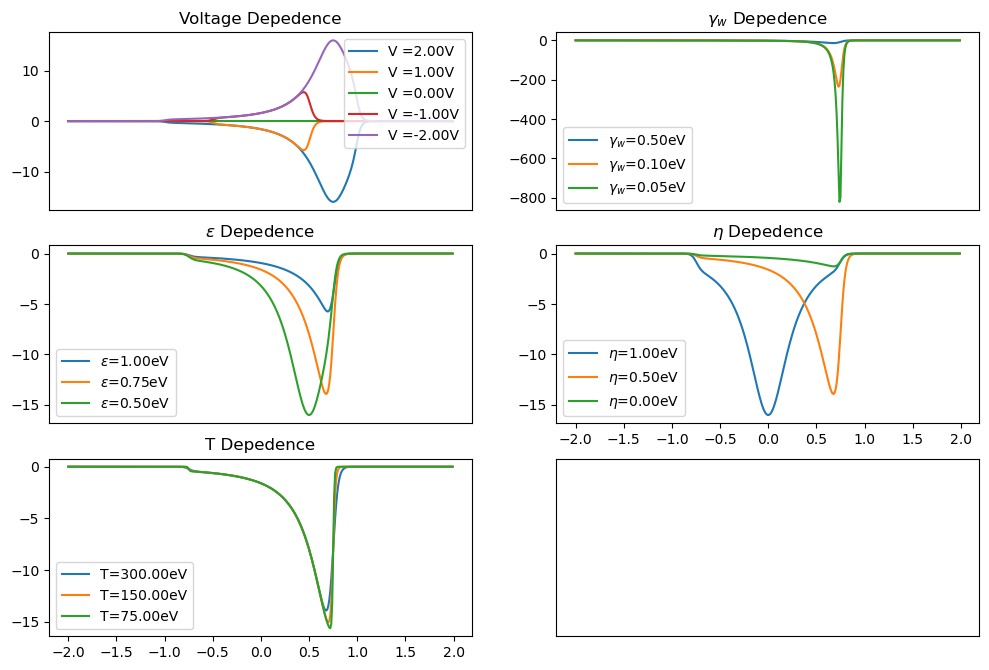

In [83]:
hideCode()

### Timing the Landauer Calculation

In [3]:
import time
# Calculating the current from -2V to 2V at steps of 0.01V
V = np.arange(-2,2,.01)
start = time.time()    # This calculates the time it takes.
ILan = vecCurrent(V, 0.001,0.5,0.75,0.5, 300)
print(time.time()-start)

2.257963180541992


Note here that it took 2.4 seconds to calculate 400 data points. If we were incorporating the doule integral from the gaussian it would take much longer than that. I've done a lot of work on finding out ways to decrease this time that I don't show here. I'll explain one way in a couple of slides, but the functions I use can be found on my [github](https://github.com/cnickle/penguins/tree/develop)

![title](github.png)

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

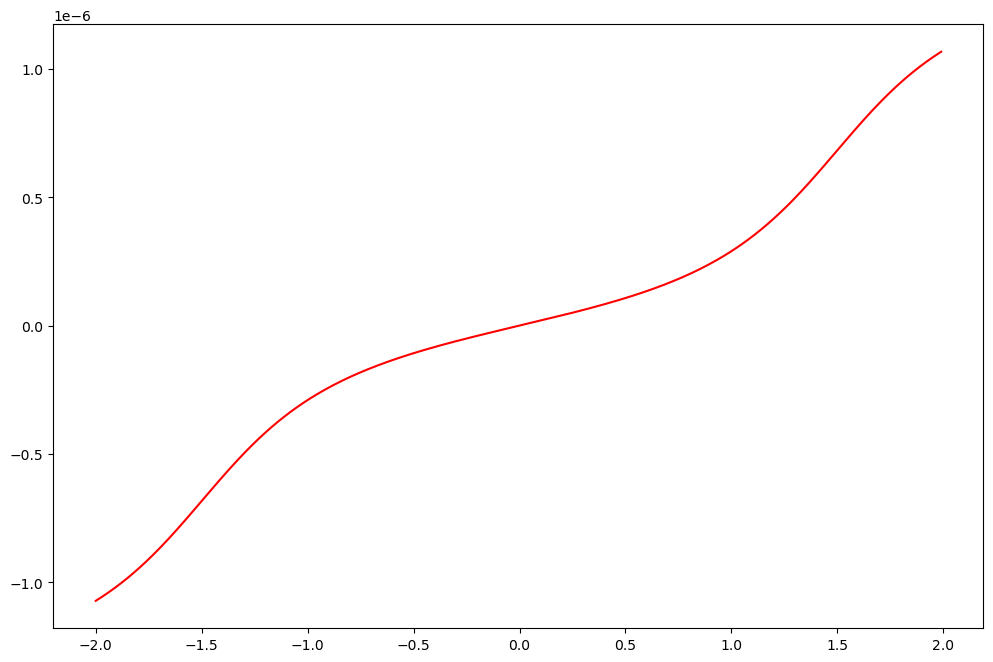

In [5]:
plt.plot(V,ILan, color = 'red')

### The Effect the Parameters have on the Curve

In [8]:
def hideCode():
    V = np.arange(-2,2,.01)
    fig, ax = plt.subplots(2, 2)

    for gamC in [0.001,0.01,0.1]:
        curr = vecCurrent(V, gamC,0.05,0.75,0.5, 300)
        ax[0][0].plot(V,np.abs(curr), label = '$\gamma_c$ =%.2fV'%(gamC))
    ax[0][0].legend()
    ax[0][0].set_title("$\gamma_c$ Depedence")
    ax[0][0].set_xticks([])
    ax[0][0].set_yscale('log')
    ax[0][0].set_ylim(10**-8,10**-2)

    for gamW in [0.075,0.05,0.025]:
        curr = vecCurrent(V, 0.01,gamW,0.75,0.5, 300)
        ax[0][1].plot(V,np.abs(curr), label = '$\gamma_w$=%.2feV'%(gamW))
    ax[0][1].legend()
    ax[0][1].set_title("$\gamma_w$ Depedence")
    ax[0][1].set_xticks([])
    ax[0][1].set_yscale('log')
    ax[0][1].set_ylim(10**-8,10**-3)

    for epsilon in [1.00,0.75,0.50]:
        curr = vecCurrent(V,0.01,0.05,epsilon,0.5, 300)
        ax[1][0].plot(V,np.abs(curr), label = '$\epsilon$=%.2feV'%(epsilon))
    ax[1][0].legend()
    ax[1][0].set_title("$\epsilon$ Depedence")
    ax[1][0].set_yscale('log')
    ax[1][0].set_ylim(10**-8,10**-3)

    for eta in [1.00,0.5,0]:
        curr = vecCurrent(V,0.01,0.05,0.75,eta, 300)
        ax[1][1].plot(V,np.abs(curr), label = '$\eta$=%.2feV'%(eta))
    ax[1][1].legend()
    ax[1][1].set_title("$\eta$ Depedence")
    ax[1][1].set_yscale('log')
    ax[1][1].set_ylim(10**-8,10**-3)

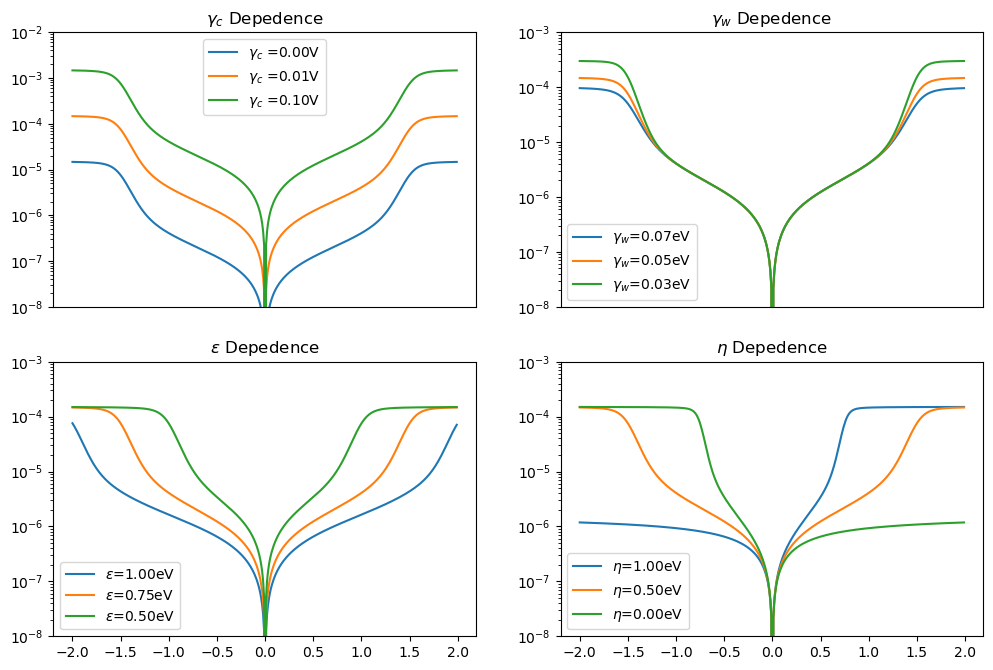

In [9]:
hideCode()

## Incorporating the Gaussian

When dealing with SAM junctions, a gaussian distribution is used to account for the fact that the molecules in the junction do not necessarily sit in the junction the same way. The connections to the electrodes would be normally distributed. Hence the need for a gaussian. Furthermore, each of the molecules is contributing to the current in parrallel. Since Landauer describes the current through a single molecule the value 'n' is added to describe the current through 'n' number of molecules. 

$$I = \dfrac{nq}{\hbar}\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}dE G_{\epsilon}(E')D_{E'}(E)\Gamma\left[f_L(E)-f_R(E)\right]$$

where:

$$G_\epsilon(E') = Ae^{\dfrac{\left(E'-\epsilon\right)^2}{2\sigma^2}}$$

A is the normalization constant, and $\sigma$ is the width of the dispersion.

### Simplifying the SAM Landauer
<br>
$$I = \dfrac{n\gamma_cq}{2\hbar}\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} \dfrac{G_{\epsilon}(E')\left[f_L(E)-f_R(E)\right]}{\left(E-\left(\epsilon+\left(\eta-\frac{1}{2}\right)v\right)\right)^2+\left(\frac{\gamma_w}{2}\right)^2}dE\tag{2}$$
<br>

Note that 'n' and $\gamma_c$ are right next to each other in the fit. This makes them essentially indistiguishable from each other as far as the fit is concerned. There are an infinite number of combinations of n and $\gamma_c$ that will give the same value for I. Therefore, I often fit this function by letting $\alpha = n\gamma_c$. Then later choosing a reasonable value for n (n = 100 for instance) and then calculating $\gamma_c = \frac{\alpha}{n}$. However you choose to do it, the point is that with n and $\gamma_c$ both sitting outside the integral one of them has to be fixed at a given value.

In [10]:
# Coding it Up
from scipy.integrate import dblquad
def gaussian(x,A, mu,sigma):
    return A*np.exp(-.5*((x-mu)/(sigma))**2)

def landauerCurrentGauss(vb, n, gammaC, gammaW, epsilon, eta, sigma, T):
    A = 1
    args = (A,epsilon,sigma)
    A = 1/quad(gaussian,epsilon-3*sigma,epsilon+3*sigma,args=args)[0]

    limits = [min([epsilon-3*sigma,-1*np.abs(vb)]),\
              max([epsilon+3*sigma,1*np.abs(vb)])]
    
    prefactor = -n*q*gammaC/(2*h)    
    def integrand (E,ep):
        result = gaussian(ep,A,epsilon,sigma)*(fermi(E+vb/2,T)-fermi(E-vb/2,T))/(((E-epsilon+(eta-1/2)*vb)**2+(gammaW/2)**2))
        return result

    return prefactor*dblquad(integrand,
                       limits[0],
                       limits[1],
                       lambda x: limits[0],
                       lambda x: limits[1])[0]
vecCurrentGauss = np.vectorize(landauerCurrentGauss)

### Timing the SAM Version

In [11]:
start = time.time()
IGau = vecCurrentGauss(V, 1,0.001,0.25,0.75,0.5,0.5, 300)
print(time.time()-start)

114.3174057006836


Here we see that calulating the guassian for a single run of 400 data points takes 2 full minute. I have managed to speed up the process quite a bit. Using a few methods including the 'jit' package to compile the functions. The functions I have defined for this that have been sped up considerably can be found in my github repository [penguins](https://github.com/cnickle/penguins/blob/develop/penquins/functions.py). However, using a Gaussian still does slow things down considerably. Another way to speed things up could be to use the cluster. Ran was working on that at one point.

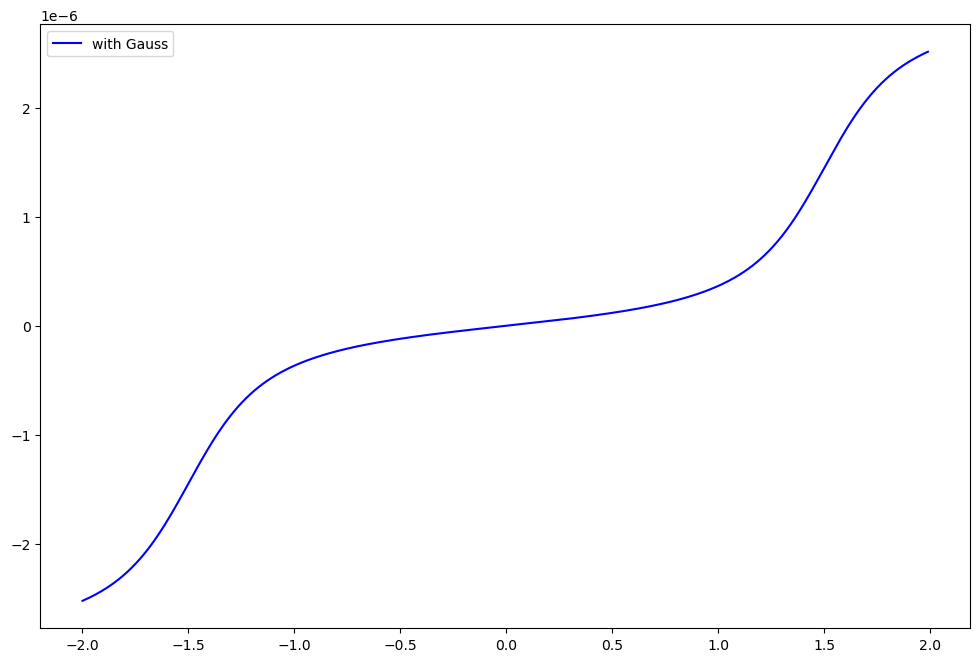

In [12]:
plt.figure()
plt.plot(V,IGau, color = 'blue', label = 'with Gauss')
plt.legend()

Using the Functions I defined in my [github](https://github.com/cnickle/penguins/blob/develop/penquins/functions.py)

In [13]:
from functions import tunnelmodel_singleLevel
vecCurrentQuickGuass = np.vectorize(tunnelmodel_singleLevel)

start = time.time()
IQui = vecCurrentQuickGuass(V,1, 0.001,0.25, 0.75,0.5,0.5,0,0,300)
print(time.time()-start)

37.36112451553345


As you can see above, using the gaussian method defined in the 'functions' file from github, the total time was about 1/4 of what it was before. So utilize the functios I've already created whenever possible because I spent a lot of time trying to speed them up. :) Now on to the fitting

# Fitting Basics

There are several different ways to fit data in python. The package I've used in the work for my thesis for fitting is [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html).

<p>There are 4 main functions I've used for minimization. However, there are many to choose from which might provide better results depending on the situation.</p>

1. [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit)

2. [scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares)

3. [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

4. [scipy.optimize.differential_evolution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution)

Let me show how each of these is used.

First we'll start with defining a simple function, and plotting it.

## Linear Fit

In [15]:
import scipy.stats as stats

# Defining Function
def linear(x,m,b):
    return m*x+b
vecLinear = np.vectorize(linear) #Vectorize function

# These are our the values of r our linear parameters
m = 2
b = -1
msig = 0.05
bsig = 0.05

# These are the x values we will use
X = np.arange(-1,1,.1)

# The M and B values are randomized using the normal distribution provided by scipy.stats
M = stats.norm.rvs(loc = m, scale = msig, size = len(X))
B = stats.norm.rvs(loc = b, scale = bsig, size = len(X))

# Calculating Y
Y = vecLinear(X,M,B)

Here we define a function "linear" we use [numpy](https://numpy.org/) to 'vectorize' the function. In other words, after we 'vectorize' the function we can start making the arguments lists rather than just scalars. 

Next we define our slope and y-interecept (m and b). However, since we're experimentalists and no data is ever perfect, we add some noise to our two variables using the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) function "norm". This is a 'normal distribution centered at the values for m and b.

Finally we use the randomized values for m and b, to calculate Y from our vectorized linear function and we plot Y vs X in the scatter plot. Since this is randomaized, each time you run the cell you'll get a slightly different result. Overall though it should like like a linear line with a little noise added to it. Now we're going to attempt to fit that line using the first method listed above: curve_fit

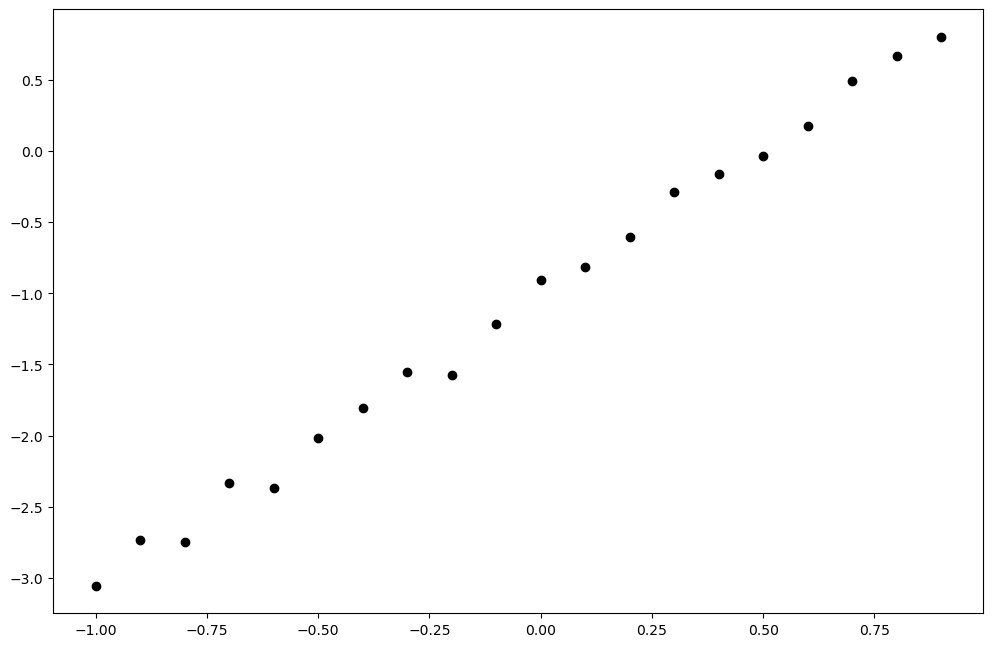

In [16]:
# Plotting our 'Experimental' values
plt.figure('Linear Fit')
plt.scatter(X,Y, color = 'black')

### Fitting the Linear Function with Curve_Fit()

In [17]:
import scipy.optimize as sco

# Fitting with sco.curve_fit
pars, cov = sco.curve_fit(linear,X,Y)

# Calculate Y using the parameters determined by curve_fit
Ythr = vecLinear(X,*pars)

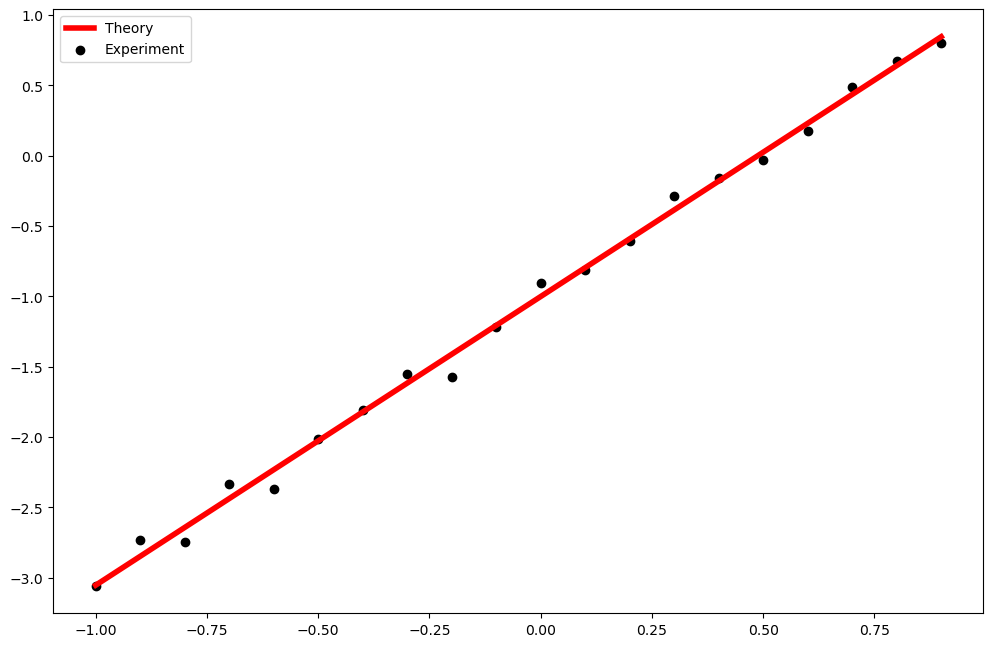

In [18]:
# Plotting the 'Experiment' vs the 'Theory'
plt.figure('Linear Fit')
plt.scatter(X,Y, color = 'black', label = 'Experiment')
plt.plot(X,Ythr,color = 'red', label = 'Theory', linewidth = 4)
plt.legend()

Alright so it looks like it did a decent job of fitting the data. However, what were the exact values of the parameters and how close were they to the values we gave?

In [19]:
mFit = pars[0]
bFit = pars[1]

parErrs = np.sqrt(np.diag(cov))
mThrErr = parErrs[0]
bThrErr = parErrs[1]

Output = 'The parameters are:\n'
Output += '\tExp\t\tThry\n'
Output += u'm:\t%.2f \u00B1 %.2f\t%.2f \u00B1 %.2f\n' %(m,msig,mFit,mThrErr)
Output += u'b:\t%.2f \u00B1 %.2f\t%.2f \u00B1 %.2f'   %(b,bsig,bFit,bThrErr)
print(Output)

The parameters are:
	Exp		Thry
m:	2.00 ± 0.05	2.05 ± 0.03
b:	-1.00 ± 0.05	-1.00 ± 0.02


So as we can see here, the fitted values are within 1 standard deviation of the 'experimental' values. As desired.

## Comparison of Fitting Functions

The linear fit was too easy. So we'll create a more complicated function and we'll use it as a comparision of different functions. We're going to add an offset to give the data points some dispersion. By adjusting the 'offset' here we can change the dispersion of the points. A larger offset will cause this to be more difficult to fit. Now that we have our complicated function with our complicated data points. Lets first start with curve_fit and move on down the line

In [31]:
def complicated(x,A,B,C):
    return ((A-x)**3)*np.sin(B*x)/(1-np.exp(C*x))
vecComp = np.vectorize(complicated)

a = 1
b = 3
c = .25

X = np.arange(0.01,2*np.pi,.01)
YExac = vecComp(X,a,b,c)

Offset = 0.025

A = stats.norm.rvs(loc = a, scale = a*Offset, size = len(X))
B = stats.norm.rvs(loc = b, scale = b*Offset, size = len(X))
C = stats.norm.rvs(loc = c, scale = c*Offset, size = len(X))

YExp = vecComp(X,A,B,C)

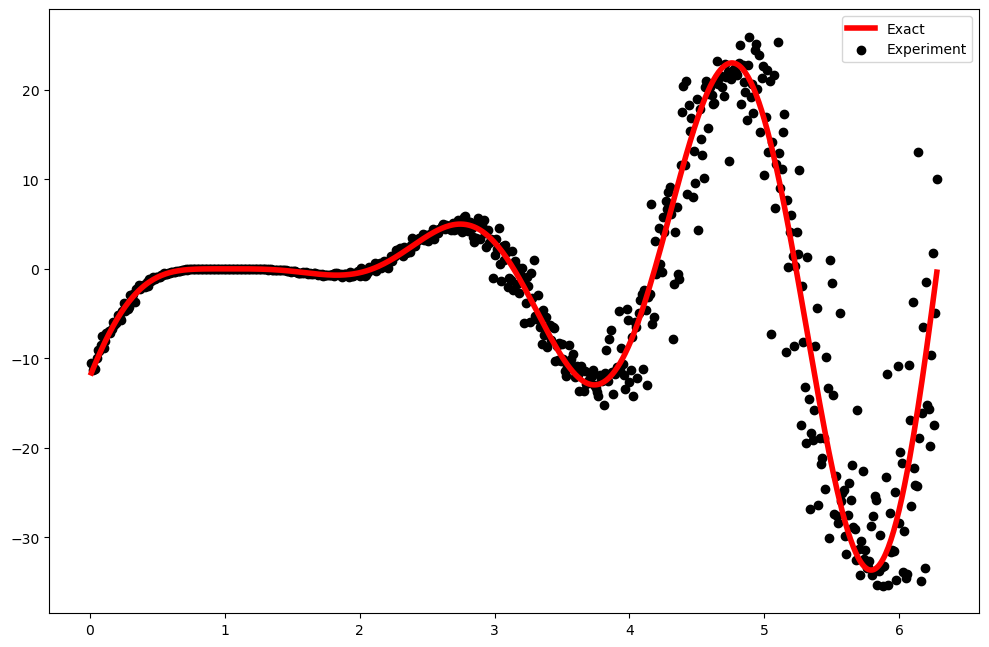

In [21]:
plt.scatter(X,YExp,color = 'black', label = 'Experiment')
plt.plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
plt.legend()

### Fitting with Each Algorithm

In [45]:
#Setting the Initial Parameters
ActValues = [1,3,.25]
Initpars  = [0,2.50,0.70]
bounds    = [[-1,1],[0.01,10],[0.01,10]]

# Defining the minFuncs
def minfunc_LS(args):                # minFunc for Least Squares
    Y_LS = vecComp(X,*args)
    return np.subtract(Y_LS,YExp)
def minfunc_min(args):               # minFunc for minimize and diff
    Y_min = vecComp(X,*args)
    res = np.subtract(Y_min,YExp)
    return np.sqrt(np.sum(res**2))

# Fitting
pars_CF, cov = sco.curve_fit(complicated,X,YExp, p0=Initpars)        
result_LS    = sco.least_squares(minfunc_LS,x0=Initpars)              
result_min   = sco.minimize(minfunc,x0=Initpars)                      
result_diff  = sco.differential_evolution(minfunc_min,bounds = bounds) 

# Calculate Y using the parameters determined by fits
Y_CF   = vecComp(X,*pars_CF)
Y_LS   = vecComp(X,*result_LS.x)
Y_min  = vecComp(X,*result_min.x)
Y_diff = vecComp(X,*result_diff.x)

In [44]:
def hideCode():
    fig, ax = plt.subplots(2, 2)
    ax[0][0].scatter(X,YExp,color = 'black', label = 'Experiment')
    ax[0][0].plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
    ax[0][0].plot(X,Y_CF, color = 'blue', label = 'curve_fit()', linewidth = 4)
    ax[0][0].legend()
    
    ax[0][1].scatter(X,YExp,color = 'black', label = 'Experiment')
    ax[0][1].plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
    ax[0][1].plot(X,Y_LS, color = 'green', label = 'least_squares()', linewidth = 4)
    ax[0][1].legend()
    
    ax[1][0].scatter(X,YExp,color = 'black', label = 'Experiment')
    ax[1][0].plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
    ax[1][0].plot(X,Y_min, color = 'orange', label = 'minimize()', linewidth = 4)
    ax[1][0].legend()
    
    ax[1][1].scatter(X,YExp,color = 'black', label = 'Experiment')
    ax[1][1].plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
    ax[1][1].plot(X,Y_diff, color = 'pink', label = 'diff_evo()', linewidth = 4)
    ax[1][1].legend()

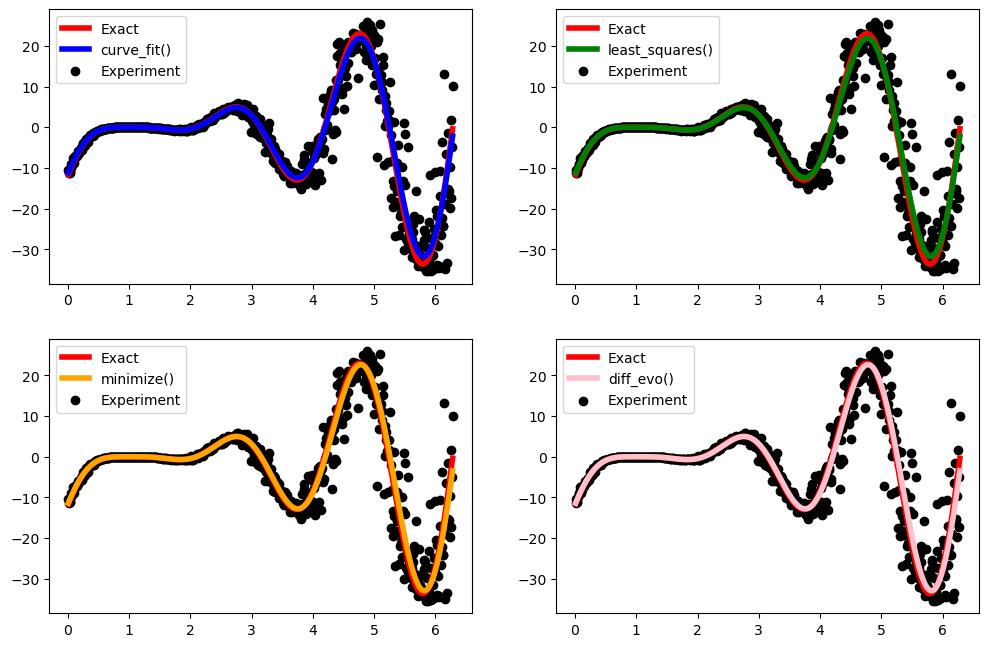

In [46]:
hideCode()

Here we see all four fitting methods together. Note the easiest to use is curve_fit() without a doubt. You don't even need to vectorize. The least_squares() function requires the user to define a 'minifunc' that returns the residual between the theory and data. If the results produced by curve_fit() and least_squares() looks similar, it's because they are. curve_fit() calls the least_squares() function itself.

We also see minimize() and diff_evo(). These two also look similar and both use a minfunc() that returns a single value. minimize() and diff_evo() will seek to make the value returned by minfunc() to be as small as possible.  

curve_fit(), least_squares() and minimize() all require initial parameters to start. differential_evolution() does not need the user to provide initial parameters. Intsead it only requires bounds. It chooses initial values at random within those bounds and slowly converges. The three that require initial parameters can also use bounds, however things can get complicated. Each requires a different format for it's arguments. 

Finally, as you can see here the 'differential_evolution()' algorthim converges to the right answer despite not receiving initial parameters and having very wide bounds \[0.01,10\]. However, there is one main problem with this method, it takes a much longer time to converge than any of the other methods discussed.

Next, we'll compare the time frames and ecffectivness.

### Comparing Time

In [84]:
import time

ExactParams = {
    'A' : 1.00,
    'B' : 3.00,
    'C' : 0.25
}

InitParams = {
    'A' : 0.00,
    'B' : 2.50,
    'C' : 0.70
}

Bounds = {
    'A' : [0.01, 4],
    'B' : [0.01, 4],
    'C' : [0.01, 4]
}

Exp_Noise = 0.025 #The 'experimental' Noise

# Setting up X
X = np.arange(0.01,2*np.pi,.01)

# Setting up the Experimetnal Y values
A = stats.norm.rvs(loc = a, scale = a*Exp_Noise, size = len(X))
B = stats.norm.rvs(loc = b, scale = b*Exp_Noise, size = len(X))
C = stats.norm.rvs(loc = c, scale = c*Exp_Noise, size = len(X))

# Calculating the Experimental Y and Exact Y values:
Y_Exp    = vecComp(X,A,B,C)

# Setting up the two different minfuncs that will need to be used. Note the differences.
def minfunc_res(args):
    Y_LS = vecComp(X,*args)
    res = np.subtract(Y_LS,YExp)
    return res

def minfunc_diff(args):
    Y_LS = vecComp(X,*args)
    res = np.subtract(Y_LS,YExp)
    return np.sum(np.sqrt(res**2))

# Doing all the Fits and timing them
start         = time.time()
Y_Exac        = vecComp(X,*ExactParams.values())
time_Exac     = time.time()-start

start         = time.time()
result_LS     = sco.least_squares(minfunc_res,x0=list(InitParams.values()))
time_LS       = time.time()-start

start         = time.time()
result_min    = sco.minimize(minfunc_diff,x0=list(InitParams.values()))
time_min      = time.time()-start

start         = time.time()
result_diff   = sco.differential_evolution(minfunc_diff,bounds = list(Bounds.values()))
time_diff     = time.time()-start

# Calculate the Y values for each fit:
Y_LS    = vecComp(X,*result_LS.x)
Y_min   = vecComp(X,*result_min.x)
Y_diff  = vecComp(X,*result_diff.x)

# Calculate the Errors for each fit
Err_Exac  = minfunc_diff(list(ExactParams.values()))
Err_LS    = minfunc_diff(result_LS.x)
Err_min   = result_min.fun
Err_diff  = result_diff.fun

def hideCode():
    #Plotting all of the results:
    plt.figure()
    plt.scatter(X, Y_Exp,  color = 'black',  linewidth = 3, label= 'Experiment')
    plt.plot(   X, Y_Exac, color = 'red',    linewidth = 3, label= 'Exact %.2fms'%(time_Exac*1000))
    plt.plot(   X, Y_LS,   color = 'blue',   linewidth = 3, label= 'least_square %.2fs'%time_LS)
    plt.plot(   X, Y_min,  color = 'green',  linewidth = 3, label= 'minimize %.2fs'%time_min)
    plt.plot(   X, Y_diff, color = 'orange', linewidth = 3, label= 'differential_evolution %.2fs'%time_diff, linestyle = 'dotted')
    plt.legend()

    output = 'Summary of Results\n'
    output += '\tMethod\t\t\tError\t\tTime\n'
    output += '\tExact\t\t\t%.2f\t\t%.2fms\n'%(Err_Exac,time_Exac*1000)
    output += '\tleast_squares\t\t%.2f\t\t%.2fms\n'%(Err_LS,time_LS*1000)
    output += '\tminimized\t\t%.2f\t\t%.2fms\n'%(Err_min,time_min*1000)
    output += '\tdifferential_evolution\t%.2f\t\t%.2fms\n'%(Err_diff,time_diff*1000)
    print(output)

Summary of Results
	Method			Error		Time
	Exact			1390.22		3.99ms
	least_squares		1375.31		261.30ms
	minimized		1358.41		1213.75ms
	differential_evolution	1358.40		4529.89ms



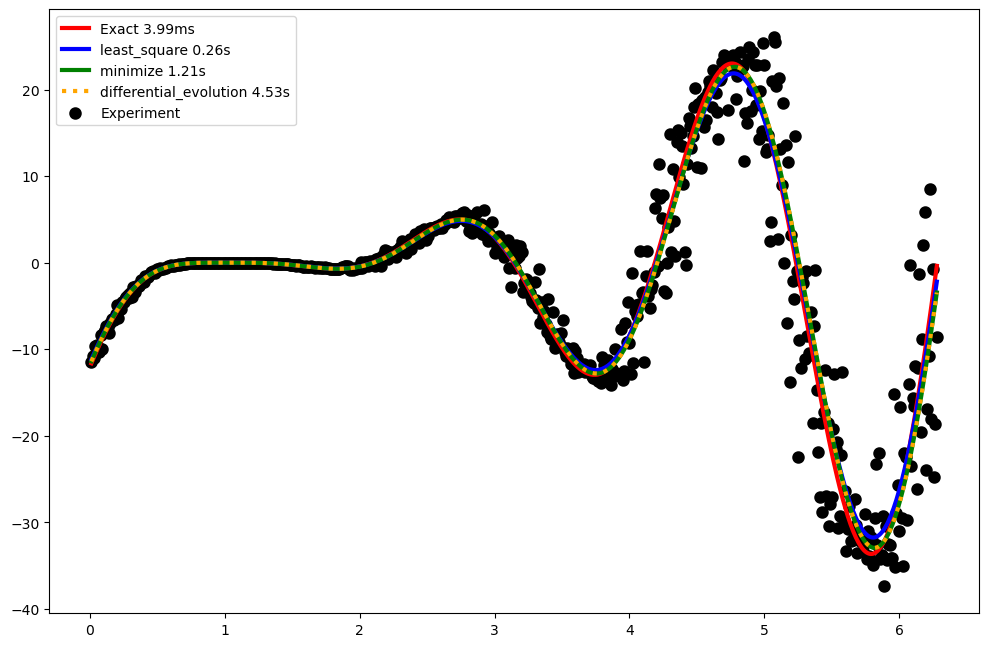

In [85]:
hideCode()

Note. Since these also use an unseeded random generator to produce the data points. Therefore, the results vary from run to run. (You can always provide a seed to keep it constant, but I've just choosen not to in this case.)

First thing to note is that the time it takes to calculate the exact function is a few ms. Note this, because when calculating the landauer equation, the computation time can be increased significantly. This is due to calculation of the numerical integral. When we utilize the gaussian for SAM junctions, the computation time goes up exponentially due to it being a double numerical integral. This is why I'm doing this with a 'relatively' simple equation that has a short computation time.

Now on to the Fittings. The below Table is a copy of the Summary of Results produced for my system and random generator seed:


| Method                 	| Error   	| Time    	|
|------------------------	|---------	|---------	|
| Exact                  	| 1405.72 	| 2.99 ms 	|
| least_squares          	| 1388.78 	| 0.30 s  	|
| minimize               	| 1378.27 	| 1.13 s  	|
| differential_evolution 	| 1378.52 	| 4.40 s  	|

So I calculated the error, which is really just the summed difference between each theory point and each 'experimental' point. Note that the 'Exact' method has an error of 1405. This is due to the noise I added to the experimental data. This interestingly resulted in the fits being closer to the experimental data than the exact calculation. Note that least_squares was the least effective, but by far the fastest. It was roughly 7 times faster that doesn't look like much now but for more complicated functions 7 times could be the difference between 30 minutes and 3.5 hours. The minimize function and the differential_evolution functions got nearly the exact same error, but diff_evo took twice as long. However, diff_evo did not rely on a user's 'guess' it just needed the bounds of what's reasonable. This makes diff_evo very powerful. Let's now start to move the initial parameters further from the 'correct' values and see what happens.

#### Failure of least_squares()

In [87]:
ExactParams = {
    'A' : 1.00,
    'B' : 3.00,
    'C' : 0.25
}

InitParams = {
    'A' : 0.00,
    'B' : 3.75,
    'C' : 0.25
}

Bounds = {
    'A' : [0.01, 3],
    'B' : [0.01, 4],
    'C' : [0.01, 2]
}

Exp_Noise = 0.025 #The 'experimental' Noise

# Setting up X
X = np.arange(0.01,2*np.pi,.01)

# Setting up the Experimetnal Y values
A = stats.norm.rvs(loc = a, scale = a*Exp_Noise, size = len(X))
B = stats.norm.rvs(loc = b, scale = b*Exp_Noise, size = len(X))
C = stats.norm.rvs(loc = c, scale = c*Exp_Noise, size = len(X))

# Calculating the Experimental Y and Exact Y values:
Y_Exp    = vecComp(X,A,B,C)

# Doing all the Fits and timing them
start         = time.time()
Y_Exac        = vecComp(X,*ExactParams.values())
time_Exac     = time.time()-start

start         = time.time()
result_LS     = sco.least_squares(minfunc_res,x0=list(InitParams.values()))
time_LS       = time.time()-start

start         = time.time()
result_min    = sco.minimize(minfunc_diff,x0=list(InitParams.values()))
time_min      = time.time()-start

start         = time.time()
result_diff   = sco.differential_evolution(minfunc_diff,bounds = list(Bounds.values()))
time_diff     = time.time()-start

# Calculate the Y values for each fit:
Y_LS    = vecComp(X,*result_LS.x)
Y_min   = vecComp(X,*result_min.x)
Y_diff  = vecComp(X,*result_diff.x)

# Calculate the Errors for each fit
Err_Exac  = minfunc_diff(list(ExactParams.values()))
Err_LS    = minfunc_diff(result_LS.x)
Err_min   = result_min.fun
Err_diff  = result_diff.fun

output = 'Summary of Results\n'
output += '\tMethod\t\t\tError\t\tTime\n'
output += '\tExact\t\t\t%.2f\t\t%.2fms\n'%(Err_Exac,time_Exac*1000)
output += '\tleast_squares\t\t%.2f\t\t%.2fs\n'%(Err_LS,time_LS)
output += '\tminimized\t\t%.2f\t\t%.2fs\n'%(Err_min,time_min)
output += '\tdifferential_evolution\t%.2f\t\t%.2fs\n'%(Err_diff,time_diff)
print(output)

def hideCode():
    #Plotting all of the results:
    plt.figure()
    plt.scatter(X, Y_Exp,  color = 'black',  linewidth = 3, label= 'Experiment')
    plt.plot(   X, Y_Exac, color = 'red',    linewidth = 3, label= 'Exact %.2fms'%(time_Exac*1000))
    plt.plot(   X, Y_LS,   color = 'blue',   linewidth = 3, label= 'least_square %.2fs'%time_LS)
    plt.plot(   X, Y_min,  color = 'green',  linewidth = 3, label= 'minimize %.2fs'%time_min)
    plt.plot(   X, Y_diff, color = 'orange', linewidth = 3, label= 'differential_evolution %.2fs'%time_diff, linestyle = 'dotted')
    plt.legend()

Summary of Results
	Method			Error		Time
	Exact			1390.22		3.99ms
	least_squares		4524.88		0.22s
	minimized		1358.41		1.27s
	differential_evolution	1358.41		4.60s



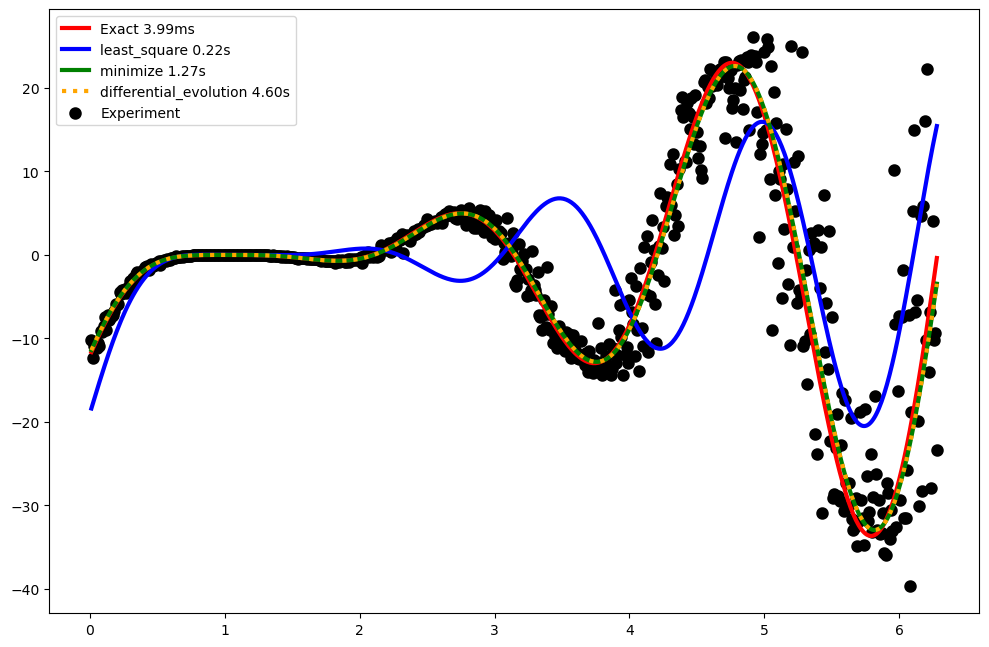

In [88]:
OldInitParams = [0.00, 2.50, 0.70]
InitParams    = [0.00, 3.75, 0.25]
bounds    = [[-1,1],[0.01,10],[0.01,10]]
hideCode()

Here we see that a slight variation in the initial parameters produces a very different result for the least_squares() fit.

### Failure of minimize()

In [89]:
ExactParams = {
    'A' : 1.00,
    'B' : 3.00,
    'C' : 0.25
}

InitParams = {
    'A' : 0.00,
    'B' : 3.75,
    'C' : 0.75
}

Bounds = {
    'A' : [0.01, 3],
    'B' : [0.01, 4],
    'C' : [0.01, 2]
}

Exp_Noise = 0.025 #The 'experimental' Noise

# Setting up X
X = np.arange(0.01,2*np.pi,.01)

# Setting up the Experimetnal Y values
A = stats.norm.rvs(loc = a, scale = a*Exp_Noise, size = len(X))
B = stats.norm.rvs(loc = b, scale = b*Exp_Noise, size = len(X))
C = stats.norm.rvs(loc = c, scale = c*Exp_Noise, size = len(X))

# Calculating the Experimental Y and Exact Y values:
Y_Exp    = vecComp(X,A,B,C)

# Doing all the Fits and timing them
start         = time.time()
Y_Exac        = vecComp(X,*ExactParams.values())
time_Exac     = time.time()-start

start         = time.time()
result_LS     = sco.least_squares(minfunc_res,x0=list(InitParams.values()))
time_LS       = time.time()-start

start         = time.time()
result_min    = sco.minimize(minfunc_diff,x0=list(InitParams.values()))
time_min      = time.time()-start

start         = time.time()
result_diff   = sco.differential_evolution(minfunc_diff,bounds = list(Bounds.values()))
time_diff     = time.time()-start

# Calculate the Y values for each fit:
Y_LS    = vecComp(X,*result_LS.x)
Y_min   = vecComp(X,*result_min.x)
Y_diff  = vecComp(X,*result_diff.x)

# Calculate the Errors for each fit
Err_Exac  = minfunc_diff(list(ExactParams.values()))
Err_LS    = minfunc_diff(result_LS.x)
Err_min   = result_min.fun
Err_diff  = result_diff.fun

output = 'Summary of Results\n'
output += '\tMethod\t\t\tError\t\tTime\n'
output += '\tExact\t\t\t%.2f\t\t%.2fms\n'%(Err_Exac,time_Exac*1000)
output += '\tleast_squares\t\t%.2f\t\t%.2fs\n'%(Err_LS,time_LS)
output += '\tminimized\t\t%.2f\t\t%.2fs\n'%(Err_min,time_min)
output += '\tdifferential_evolution\t%.2f\t\t%.2fs\n'%(Err_diff,time_diff)
print(output)

def hideCode():
    #Plotting all of the results:
    plt.figure()
    plt.scatter(X, Y_Exp,  color = 'black',  linewidth = 3, label= 'Experiment')
    plt.plot(   X, Y_Exac, color = 'red',    linewidth = 3, label= 'Exact %.2fms'%(time_Exac*1000))
    plt.plot(   X, Y_LS,   color = 'blue',   linewidth = 3, label= 'least_square %.2fs'%time_LS)
    plt.plot(   X, Y_min,  color = 'green',  linewidth = 3, label= 'minimize %.2fs'%time_min)
    plt.plot(   X, Y_diff, color = 'orange', linewidth = 3, label= 'differential_evolution %.2fs'%time_diff, linestyle = 'dotted')
    plt.legend()

Summary of Results
	Method			Error		Time
	Exact			1390.22		3.99ms
	least_squares		1375.31		0.25s
	minimized		4391.96		1.37s
	differential_evolution	1358.40		3.62s



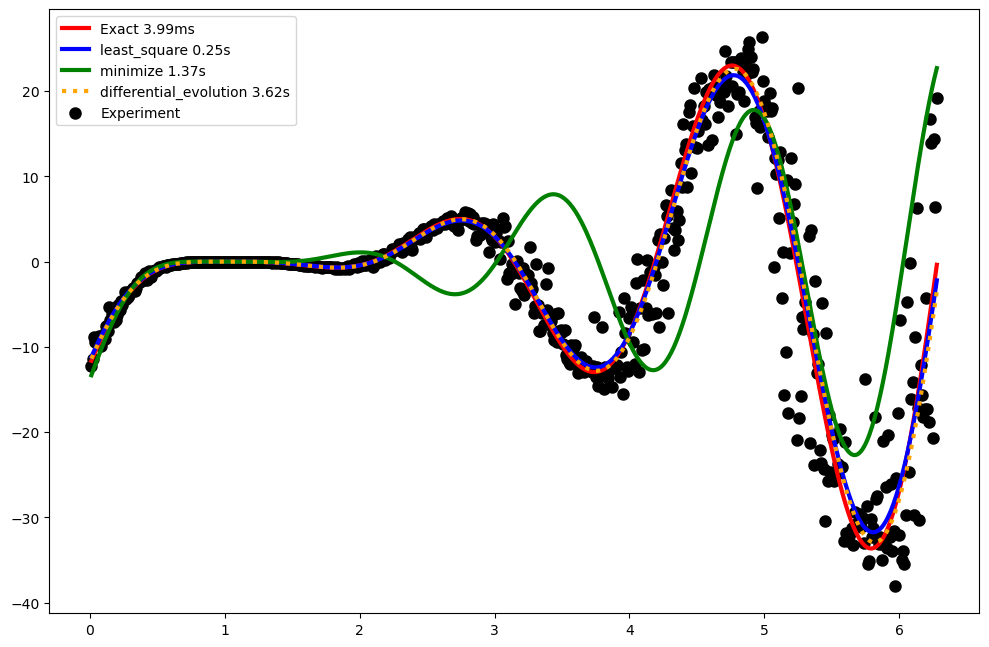

In [90]:
hideCode()

## Summary

Here, I have shown several basic fitting techniques using python. This is by no means an exhaustive list. And I haven't even gone into the different options one can utilize with each of the fitting methods. What I have shown however is a few of the ones that I've used most often. I have also shown their limitations. In ideal situations they all give nearly the same result. However, just by changing the initial parameters, I can show how in some cases one function works better than the other and vice versa. In the last case, setting C = .70 allows the 'minimize()' function to fit perfectly, but C=0.75 gives a completely nonsensical result, a less than 10% change in one of the three variables was the difference between convergences and non convergence showing how important initial parameters are. While diff_evo almost always returned the same result, that too however can get stuck in local minimums.

Ultimately, it comes down to, there is no easy solution when dealing with complicated functions. That are a lot of fitting methods, but each has thier pros and cons and none work in every situation. Furthermore, calculation time is also something that needs to be considered as different methods have different calculation times, some like diff_evo can go on for days if the bounds are wide enough.

# Utilizing Penguins

After the second or third fitting attempt, I realized that I use some of the same techniques over and over again. Therefore, I started to create a package which places all of those useful functions in one location and makes it easy for the user to access. I'm going to go through how to use them here.

## Visualizing the Data with Pandas

In [32]:
import pandas as pd
data = pd.read_csv('10.txt', delimiter = '\t')
data.columns = ['V','abs(J)','J','V2','I']

In [36]:
def hideCode():
    plt.scatter(data['V'],np.abs(data['I']),color = 'black')
    plt.yscale('log')

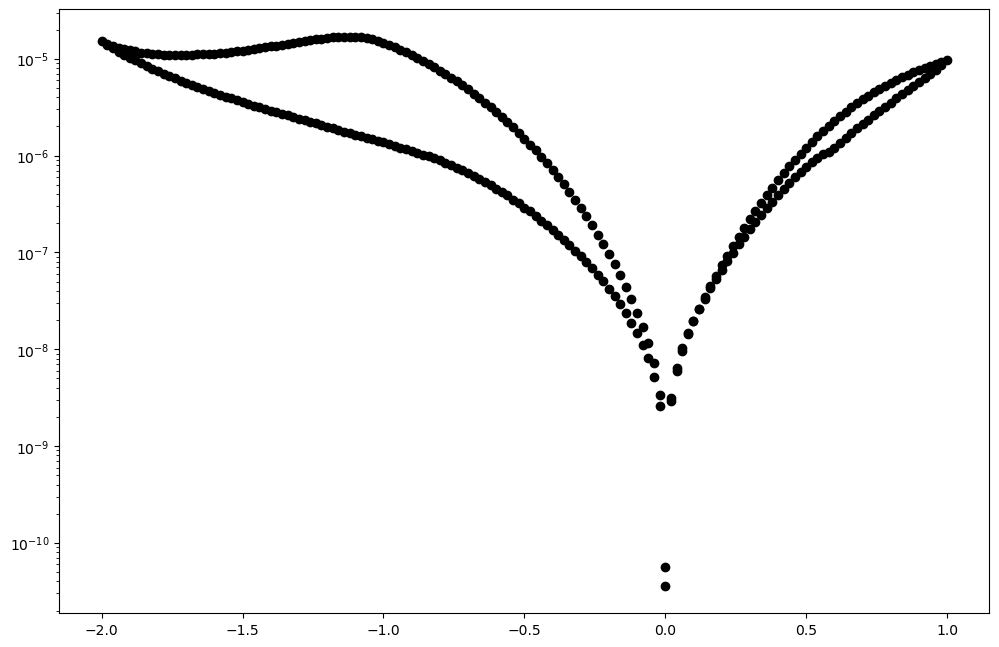

In [33]:
hideCode()

We're going to use some data from the current project I'm working on. We first utilize the 'pandas' package to read the data into a dataframe. And then we can easily visualize it using matplotlib.pyplot.

Now we're going to utilize the functions from gitHub to simply call the fitting function rather than having to create it from scratch. We'll start by creating a dictionary of all of our parameters that we intend to use

In [23]:
initpar = {
        'n'     :    150,
        'gammaL':    6.73e-04,
        'gammaR':    0.13,
        'kappa' :    1.25,
        'sigma' :    0,
        'E_AB'  :    0.46,
        'E_AC'  :    2.3,
        'chi'   :    0.6,
        'eta'   :    0.54,
        'gam'   :    0.31,
        'lam'   :    4.1,
        'P'     :    0,
        'u'     :    0.01,
        'c'     :    0,
        'vg'    :    0,
        'T'     :    300
    }

In [24]:
Fixed = {
    'n'    :    150,
    'sigma':    0,
    'P'    :    0,
    'u'    :    0.01,
    'c'    :    0,
    'vg'   :    0,
    'T'    :    300
    }

In [25]:
fixed = list(Fixed.keys())
for par in Fixed.keys():
    initpar[par] = Fixed[par]

In [26]:
bnds = {
    'n'       : [0    , 200.],
    'gammaL'  : [1E-11, 0.024],
    'gammaR'  : [1E-11, 0.17],
    'kappa'   : [1E-11 , 9.5],
    'sigma'   : [1E-11, 0.50],
    'E_AB'    : [0.39 , 0.93],
    'E_AC'    : [-1.53 , 2.3],
    'chi'     : [1E-11 , 3.12],
    'eta'     : [0.36 , 0.82],
    'gam'     : [1E-11, 2.65],
    'lam'     : [1E-11, 4.6]
    }

In [34]:
from Model import Model as mod
from functions import HysteresisModel as HystModel

NitzModel = mod(HystModel)
NitzModel.setParams(initpar,fixed=fixed,bnds=bnds)
NitzModel.fit(data['V'],data['I'])

This creates a new instance of this class. Our 'Model' will be the HysteresisModel that is already defined in functions.py however, any user defined function can be used here. Now we're going to define our initial parameters and our fixed parameters.

In [35]:
NitzModel.print(data['V'],data['I'])


FIT REPORT                                
Total Fit Time: 00:00:15
Fitting Method: LS None

Parameter:		Value:
	n*			1.50e+02
	gammaL			6.55e-04
	gammaR			1.31e-01
	kappa			1.24e+00
	sigma*			0.00e+00
	E_AB			4.73e-01
	E_AC			2.30e+00
	chi			6.15e-01
	eta			5.39e-01
	gam			3.04e-01
	lam			4.11e+00
	P*			0.00e+00
	u*			1.00e-02
	c*			0.00e+00
	vg*			0.00e+00
	T*			3.00e+02
*Fixed

Error:
	Standard:		-5.09
	chi sq  :		-inf

__________________________________________



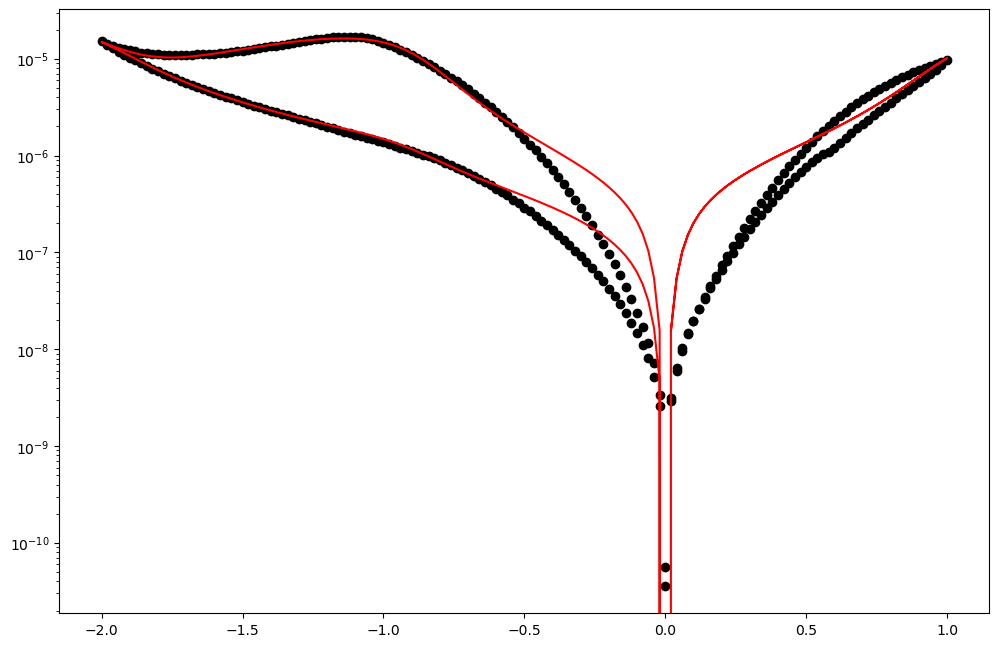

In [47]:
Ythr = NitzModel.returnThry(data['V'])
plt.scatter(data['V'],np.abs(data['I']),color = 'black')
plt.plot(data['V'], abs(Ythr), color = 'red')
plt.yscale('log')

Simple as that. However, now we're going to play with it a little, because I've added a lot of extras. Below I list a few of the extras I've coded into this class.

In [37]:
def example():
    # Now it'll fit using minimize()
    NitzModel.fit(data['V'],data['I'], algorithm = 'min')

    # Now it'll fit using differential_evolution()
    NitzModel.fit(data['V'],data['I'], algorithm = 'diff')

    # Fit with differential_evolution() and save the output from each call of the fitting function.
    NitzModel.fit(data['V'],data['I'], algorithm = 'diff', save = 'Results.txt')

    # Fit with differential_evolution() and give an update on the fitting every 50 calls of the fitting function.
    NitzModel.fit(data['V'],data['I'], algorithm = 'diff', mode = 'verbose')

In [38]:
calculatedParams ={
    'Gamma'   : lambda args: (args['gammaL']*args['gammaR'])/(args['gammaL']+args['gammaR'])
    }
NitzModel.setParams(initpar,fixed=fixed,bnds=bnds, calculatedParams=calculatedParams)
NitzModel.fit(data['V'],data['I'], algorithm = 'min', method = 'SLSQP')

In [39]:
NitzModel.print(data['V'],data['I'])


FIT REPORT                                
Total Fit Time: 00:05:16
Fitting Method: min SLSQP

Parameter:		Value:
	n*			1.50e+02
	gammaL			6.50e-04
	gammaR			1.29e-01
	kappa			1.21e+00
	sigma*			0.00e+00
	E_AB			4.73e-01
	E_AC			2.30e+00
	chi			6.14e-01
	eta			5.39e-01
	gam			3.00e-01
	lam			4.12e+00
	P*			0.00e+00
	u*			1.00e-02
	c*			0.00e+00
	vg*			0.00e+00
	T*			3.00e+02
*Fixed

Error:
	Standard:		-5.10
	chi sq  :		-inf

Calculated Param:		Value:
	Gamma				6.46e-04
__________________________________________



# Modeling Memory Molecules

In 3 different cases I've used a more complicated model to describe the junction. I have created 'test' cases that are able to exactly reproduce the projects I've worked on, and they are located on [github](https://github.com/cnickle/penguins/tree/develop/penquins/tests). The first, the 'Toy' model was used to model the data in [Nature Materials](https://www.nature.com/articles/s41563-020-0697-5) paper. The most recent one is awating publication and uses the [Migliore and Nitzan](https://pubs.acs.org/doi/abs/10.1021/ja401336u) paper  that describes hysteretic behavior in molecular junctions. I'll dicuss this in more detail due to it's complicated nature.

## Migliore and Nitzan's Model

For a hysteretic or 'memory-swtich' junction. There are two conduction regimes that contribues to the total conduction. Each of these conduction regimes are modeleding using the Landauer model represented in equations (1) and (2). They are related to the total current by equation (3)

$$I_{tot} = \mathcal{L}_{on}\mathcal{P}_{on}+\mathcal{L}_{off}\mathcal{P}_{off}\tag{3}$$

Let us first talk about the two landauers.

$$\mathcal{L}_{on} = \mathcal{L}\left(\gamma_{L_{on}},\gamma_{R_{on}},\epsilon_{on},\eta_{on},\sigma_{on},T_{on}\right)$$
$$\mathcal{L}_{off} = \mathcal{L}\left(\gamma_{L_{off}},\gamma_{R_{off}},\epsilon_{off},\eta_{off},\sigma_{off},T_{off}\right)$$

However, we start to relate the parameters to one another:

$$\begin{align}
\gamma_{{x}_{on}}  &= \gamma_{x}\\
\gamma_{{x}_{off}} &= \kappa\gamma_{x} \text{     where x= L,R}\\
\epsilon_{on}  &= \epsilon\\
\epsilon_{off} &= \epsilon +\chi\\
T_{on} &= T_{off}= T\\
\eta_{on} &= \eta_{off}= \eta\\
\sigma_{on} &= \sigma_{off}= \sigma
\end{align}$$

Essentially, we are only allowing the on and off states to differ by '$\chi$' and '$\kappa$'.

Now we should talk about the probability functions to determine if we're in the on or off states. First, since we're only considering two states, the probabilities should be related to one another by: $\mathcal{P}=\mathcal{P}_{on}=1-\mathcal{P}_{off}$ so equation (3) becomes:

$$I_{tot} = \mathcal{L}_{on}\mathcal{P}+\mathcal{L}_{off}\left(1-\mathcal{P}\right)\tag{3}$$

The probability functional itself is where things get complicated. Migliore and Nitzan don't give us a functional for the probability per se but rather for the time derivative. Here, I've used the equation number given in Migliore and Nitzan's paper.

$$\dfrac{d\mathcal{P}}{dt} = \left(1-\mathcal{P}\right)\left<k_{S0\rightarrow S1}\right>-\mathcal{P}\left<k_{S1\rightarrow S0}\right>\tag{30}$$

Now the next question is what do we use for the two k values? Nitzan gives us two options He defines them as Model A and Model B:

### Model A
<br>
<br>

$$\begin{align}
\left<k_{S0\rightarrow S1}\right> &= \left(1-n_{S0}\right)\mathcal{R}_{AC}+n_{S1}\mathcal{R}_{BD}\tag{31a}\\
\left<k_{S1\rightarrow S0}\right> &= \left(1-n_{S0}\right)\mathcal{R}_{CA}+n_{S1}\mathcal{R}_{DB}\tag{31b}
\end{align}$$

Where the R values are the Marcus ET Rates given by equation (33a) in Nitzan's paper. And Reproduced below:

$$\mathcal{R}_{XY} = \frac{\gamma}{2}\sqrt{\dfrac{\pi k_BT}{\lambda}}\exp\left[-\dfrac{\left(\alpha-\lambda\right)^2}{4\lambda k_BT}\right]\tag{33a}$$

$$\mathcal{R}_{YX} = \frac{\gamma}{2}\sqrt{\dfrac{\pi k_BT}{\lambda}}\exp\left[-\dfrac{\left(\alpha+\lambda\right)^2}{4\lambda k_BT}\right]\tag{33a}$$

where $\alpha \equiv \mu - E_{XY}+eV$

So the four Marcus rates can be written as:
$$\begin{align}
\mathcal{R}_{AC/CA} & = \frac{\gamma_{AC}}{2}\sqrt{\dfrac{\pi k_BT}{\lambda_{AC}}}\exp\left[-\dfrac{\left(E_{AC}+/-\lambda_{AC}\right)^2}{4\lambda_{AC} k_BT}\right]\\
\mathcal{R}_{BD/DB} & = \frac{\gamma_{BD}}{2}\sqrt{\dfrac{\pi k_BT}{\lambda_{BD}}}\exp\left[-\dfrac{\left(E_{BD}+/-\lambda_{BD}\right)^2}{4\lambda_{BD} k_BT}\right]
\end{align}$$

Again we relate the values of the gammas, lambdas and energies. $\gamma=\gamma_{AC}$ and $\gamma_{BD}=\kappa\gamma$. $\lambda = \lambda_{AC} = \lambda_{BD}$. Finally, $E_{BD}=E_{AC}+\chi$.

Finally, the average bridge populations take on a very similar form to that of the Landauer equation.

$$n_{sx} = \dfrac{1}{2\pi}\int_{-\infty}^{\infty}\dfrac{f_L(E)\gamma_L-f_R(E)\gamma_R}{\left(E-\left(\epsilon_{sx}+\left(\eta-\frac{1}{2}\right)v\right)\right)^2+\left(\frac{\gamma_w}{2}\right)^2}dE\tag{2}$$

### Model B

In Model B, the R values are used for the K rates, and the average bridge population is instead applied to the energies. However, we have not at this point compared the two. Opting to use Model A for the work we've done thus far.

I'm not going to start typing these equations up and plotting them.

### Marcus Rates

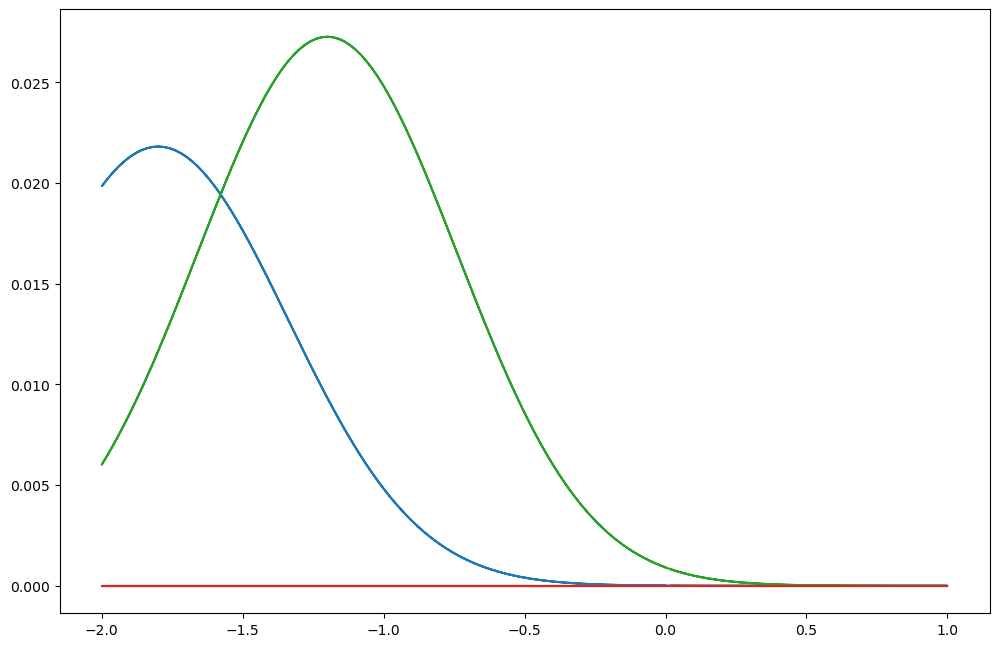

In [43]:
from functions import MarcusETRates
VecMarc = np.vectorize(MarcusETRates)

rateParsAC = {
        'gam'   :    initpar['gam'],
        'lam'   :    initpar['lam'],
        'E_AC'  :    initpar['E_AC'],
        'T'     :    initpar['T']
    }
rateParsBD = {
        'gam'   :    initpar['gam']*initpar['kappa'],
        'lam'   :    initpar['lam'],
        'E_AC'  :    initpar['E_AC']+initpar['chi'],
        'T'     :    initpar['T']
    }

R_AC, R_CA = VecMarc(data['V'],*rateParsAC.values())
R_BD, R_DB = VecMarc(data['V'],*rateParsBD.values())

plt.plot(data['V'],R_AB)
plt.plot(data['V'],R_BA)
plt.plot(data['V'],R_BD)
plt.plot(data['V'],R_DB)

In [ ]:

initpar = {
        'n'     :    150,
        'gammaL':    6.73e-04,
        'gammaR':    0.13,
        'kappa' :    1.25,
        'sigma' :    0,
        'E_AB'  :    0.46,
        'E_AC'  :    2.3,
        'chi'   :    0.6,
        'eta'   :    0.54,
        'gam'   :    0.31,
        'lam'   :    4.1,
        'P'     :    0,
        'u'     :    0.01,
        'c'     :    0,
        'vg'    :    0,
        'T'     :    300
    }